In [1]:
import QuantumToolbox as QT
using Plots, LaTeXStrings
using SelfConsistentHartreeFock

In [2]:
Fsweep = range(1e-5, 0.01, 51)
Δsweep_sparse = range(-0.01, 0.03, 51)
Δsweep = range(-0.01, 0.03, 601)
Kval = 0.001
Fval = 0.01

0.01

## Master Equation

In [3]:
function ρ_ss(Δ, F, K, γ; kwargs...)
    N = 50 # cutoff of the Hilbert space dimension
    a = QT.destroy(N) # annihilation operator

    H = -Δ * a' * a + K * a' * a' * a * a - F * (a' + a)
    c_ops = [sqrt(γ) * a]

    solver = QT.SteadyStateLinearSolver()
    ρ_ss = QT.steadystate(H, c_ops; solver, kwargs...) # Hamiltonian and collapse operators
    # real(QT.expect(a' * a, ρ_ss))
end
function ρ_ss(tt::Tuple)
    Δ, F = tt
    ρ_ss(Δ, F, Kval, 0.001)
end

N = 50 # cutoff of the Hilbert space dimension
a = QT.destroy(N) # a
nm = ρ -> real(QT.expect(a' * a, ρ))
g2m = ρ -> real(QT.expect(a' * a' * a * a, ρ) / QT.expect(a' * a, ρ)^2)

#14 (generic function with 1 method)

In [4]:
# range2d = collect(Iterators.product(Δsweep_sparse, Fsweep))
# Trange2d = [range2d[j, i] for j in 1:size(range2d, 2), i in 1:size(range2d, 1)]

# ρm = map(ρ_ss, Trange2d);

# heatmap(Δsweep_sparse, Fsweep, nm.(ρm'))

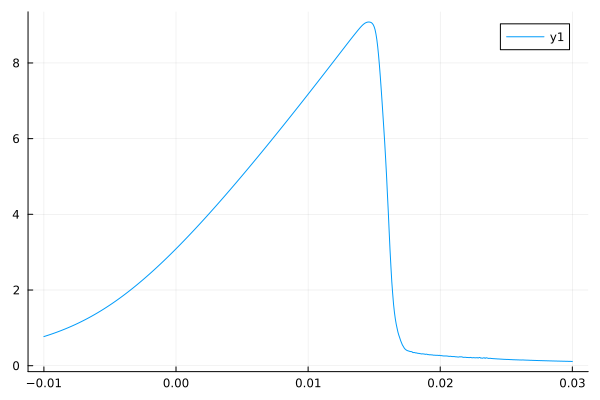

In [5]:
ρv = map(_Δ -> ρ_ss(_Δ, Fval, Kval, 0.001), Δsweep)
n_q = nm.(ρv)
plot(Δsweep, n_q)

## Meanfield

Solving via TotalDegree homotopy ... 100%|██████████████████████████████████████████████████| Time: 0:00:29


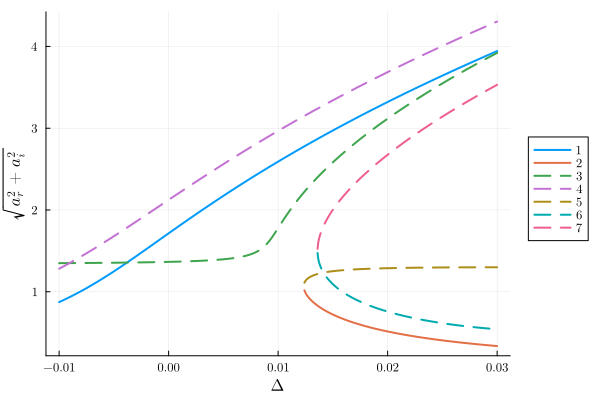

In [6]:
using QuantumCumulants, HarmonicBalance, Plots

h = FockSpace(:cavity)
@qnumbers a::Destroy(h)
@variables Δ::Real K::Real F::Real
param = [Δ, K, F]

H_RWA = -Δ * a' * a + K * (a'^2 * a^2) + F * (a' + a)
ops = [a, a']

eqs = complete(meanfield(ops, H_RWA, [a]; rates=[0.001], order=2))

fixed = (K => Kval, F => Fval)
varied = (Δ => Δsweep)
problem = HarmonicSteadyState.HomotopyContinuationProblem(eqs, param, varied, fixed)

result = get_steady_states(problem, TotalDegree())

branches = get_branches(result, "sqrt(aᵣ^2 + aᵢ^2)", class="stable")


plot(result, y="sqrt(aᵣ^2 + aᵢ^2)")

In [13]:
problem

5 algebraic equations for steady states
Variables: aᵣ, aᵢ, aaᵣ, aaᵢ, a⁺aᵣ
Parameters: Δ, K, F


In [ ]:
n_2c = branches[1]

In [7]:
# eqs = complete(meanfield(ops, H_RWA, [a]; rates=[0.001], order=3))

# fixed = (K => Kval, F => Fval)
# varied = (Δ => Δsweep)
# problem = HarmonicSteadyState.HomotopyContinuationProblem(eqs, param, varied, fixed)

# result = get_steady_states(problem, TotalDegree())

# branches = get_branches(result, "sqrt(aᵣ^2 + aᵢ^2)", class="stable")
# n_3c = branches[1]


# plot(result, y="sqrt(aᵣ^2 + aᵢ^2)")

## Hartree Fock

In [14]:
config_gaussian = SolverConfig(
    ; max_iter=20_000,
    tol=eps(),
    step_fraction=0.5,
    backtrack=8,
    step_bounds=(0.05, 0.9),
    accept_relax=0.995,
    keep_nm_zero=false,
    unstable_scale=0.2,
)
config_mean_field = SolverConfig(
    ; max_iter=20_000,
    tol=eps(),
    step_fraction=0.5,
    backtrack=8,
    step_bounds=(0.05, 0.9),
    accept_relax=0.995,
    keep_nm_zero=true,
    unstable_scale=0.2,
)
param = Params(; Δ=first(Δsweep), K=Kval, F=Fval)

Params(-0.01, 0.001, 0.01 + 0.0im)

In [15]:
cont_up = sweep_delta(collect(Δsweep), param, 1e-3 + 0im, config_gaussian)
cont_up_mean = sweep_delta(collect(Δsweep), param, 1e-3 + 0im, config_mean_field)
α_up = getfield.(cont_up, :α)
α_mean_up = getfield.(cont_up_mean, :α)
n_up = getfield.(cont_up, :n)
m_up = getfield.(cont_up, :m);

In [16]:
Δdown = reverse(collect(Δsweep))
cont_dn = sweep_delta(Δdown, param, 1e-3 + 0im, config_gaussian)
cont_dn_mean = sweep_delta(Δdown, param, 1e-3 + 0im, config_mean_field)
α_down = reverse(getfield.(cont_dn, :α))
α_mean_down = reverse(getfield.(cont_dn_mean, :α))
n_down = reverse(getfield.(cont_dn, :n))
m_down = reverse(getfield.(cont_dn, :m));

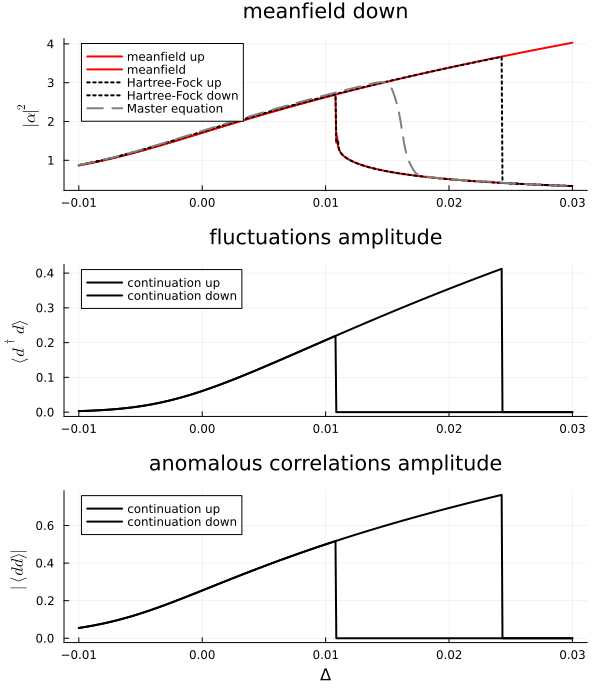

In [11]:
plt = plot(Δsweep, abs.(α_mean_up); label="meanfield up", lw=2, color=:red, xlabel="",
    ylabel=L"|α|^2", title="meanfield down")
plot!(plt, Δsweep, abs.(α_mean_down); label="meanfield", lw=2, color=:red)
plot!(plt, Δsweep, abs.(α_up); label="Hartree-Fock up", lw=2, ls=:dot, color=:black)
plot!(plt, Δsweep, abs.(α_down); label="Hartree-Fock down", lw=2, ls=:dot, color=:black)
plot!(plt, Δsweep, sqrt.(n_q); label="Master equation", lw=2, ls=:dash, color=:gray)

plt2 = plot(
    Δsweep,
    n_up;
    label="continuation up",
    lw=2,
    xlabel="",
    ylabel=L"\langle d^\dagger d \rangle",
    title="fluctuations amplitude",
    color=:black
)
plot!(plt2, Δsweep, n_down; label="continuation down", lw=2, color=:black)

plt3 = plot(
    Δsweep,
    abs.(m_up);
    label="continuation up",
    lw=2,
    xlabel="Δ",
    ylabel=L"|\langle d d \rangle|",
    title="anomalous correlations amplitude",
    color=:black
)
plot!(plt3, Δsweep, abs.(m_down); label="continuation down", lw=2, color=:black)

plot(plt, plt2, plt3; layout=(3, 1), size=(600, 700), legend=:topleft)
